In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# your function must import layout and constants
# this is structured to work both in Jupyter notebook and from the command line
try:
    from . import layout
    from . import constants
except ImportError:
    import layout
    import constants
    
from datetime import datetime
from pathlib import Path
import shutil
import socket
import psutil

In [ ]:
# fugly hack for making the library module available to the plugins
sys.path.append(layout.dir_path+'/../..')
from library import PluginTools

In [5]:
def _temperature():
    '''return a dictionary with the current CPU temperature on a raspberry pi in degrees C'''
    try:
        f = psutil.sensors_temperatures()
        current = f['cpu_thermal'][0].current
    except psutil.Error as e:
        logging.error(f'could not get CPU temperature: {e}')
        current = 0
    
    current = int(round(current,0))
    
    current = f'Temp: {current}C'
    
    return {'cputemp': current}

In [32]:
def _cpu_load():
    '''return a dicionary containing a list of the load average for 
    all cpus for 1, 5, 15 minutes as percentages'''
    try:
        load = [f'{round(x / psutil.cpu_count() * 100, 2)}%' for x in psutil.getloadavg()]
    except psutil.Error as e:
        logging.error(f'CPU info not available: {e}')
        load = ('NA', 'NA', 'NA')
        
    
        
    return {
        'cpuload_5': f'5 min avg: {load[0]}',
        'cpuload_10': f'10 min avg: {load[1]}',
        'cpuload_15': f'15 min avg: {load[2]}'
    }

In [7]:
def _network_info():
    '''return a dictionary containing the hostname and ipaddress of the host'''
    try:
        hostname = socket.gethostname()
    except OSError as e:
        logging.error(f'could not get hostname: {e}')
        hostname = 'UNKNOWN!'
    
    # based on https://stackoverflow.com/a/28950776/5530152
    s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    s.settimeout(0)
    try:
        # doesn't even have to be reachable
        s.connect(('10.254.254.254', 1))
        IP = s.getsockname()[0]
    except Exception:
        IP = '127.0.0.1'
    finally:
        s.close()
    
    return {
        'hostname': hostname,
        'ipaddress': IP
    }

In [8]:
def _disk_use(unit='GB', rounding=0 ):
    '''return a diciontary containing 
        disk_total, diskuse, diskfree in units and percentages'''
    try:
        total_b, used_b, free_b = shutil.disk_usage("/")
    except OSError as e:
        logging.error(f'could not access "/": {e}')
        total_b, used_b, free_b = 0, 0, 0
    
    if unit not in constants.storage_units.keys():
        logging.warning(f'unknown storage unit in config: "{unit}"; falling back to `GB`')
    
    my_unit = constants.storage_units.get(unit, 10**9)
    
    return {
        'disk_total': f"Total: {int(round(total_b/my_unit, 0))} {unit}",
        'diskuse': f"Used: {int(round(used_b/my_unit, 0))} {unit}",
        'diskfree': f"Free: {int(round(used_b/my_unit, 0))} {unit}",
        # prevent div/0 errors by adding 1 byte
        'diskuse_pct': f'Used: {int(round(used_b/(total_b+1)*100, 0))}%',
        'diskfree_pct': f'Free: {int(round(free_b/(total_b+1)*100, 0))}%',
        'disk_units': unit,
    }

In [9]:
# make sure this function can accept *args and **kwargs even if you don't intend to use them
def update_function(self, *args, **kwargs):
    '''update function for system_info to display system information including:
        Network Info:
            * IP address
            * Hostname
            
        Storage Info:
            * Total storage
            * Percent used
            * Percent free
            
        CPU Usage Info:
            * Temperature
            * 5 minute load average
            * 10 minute load average
            * 15 minute load average
    
    Supports RGB text
    
    Configuration Requirements:
        self.config(dict): {
            'storage_unit': 'GB' # optional units to use for storage (KB, MB, GB, TB, EB)
            'text_color': 'Black' # optional 
            'bkground_color': 'White' # optional
        }
        
    Args: 
        self(namespace): namespace from plugin object
    
    Returns:
        tuple: (is_updated(bool), data(dict), priority(int))

    %U'''   
    
    is_updated = True
    data = {}
    priority = self.max_priority
    
    data.update(_network_info())
    data.update(_disk_use(self.config['storage_unit']))
    data.update(_cpu_load())
    data.update(_temperature())
    data['time'] = datetime.now().strftime("%H:%M")
    data['disk_icon'] = Path(constants.image_path)/'hdd.jpg'
    data['cpu_icon'] = Path(constants.image_path)/'chip.jpg'
    
    if 'text_color' in self.config or 'bkground_color' in self.config:
        logging.info('using user-defined colors')
        colors = PluginTools.text_color(config=self.config, mode=self.screen_mode,
                               default_text=self.layout.get('fill', 'WHITE'),
                               default_bkground=self.layout.get('bkground', 'BLACK'))

        text_color = colors['text_color']
        bkground_color = colors['bkground_color']


        # set the colors
        logging.debug(f'trying to set fill and background for sections: {list(self.layout.keys())}')
        for section in self.layout:
            if self.layout[section].get('rgb_support', False):
                logging.debug(f'setting {section} layout colors to fill: {text_color}, bkground: {bkground_color}')
                self.layout_obj.update_block_props(section, {'fill': text_color, 'bkground': bkground_color}) 

            else:
                logging.debug(f'section {section} does not support RGB colors')
    
    
    return (is_updated, data, priority)

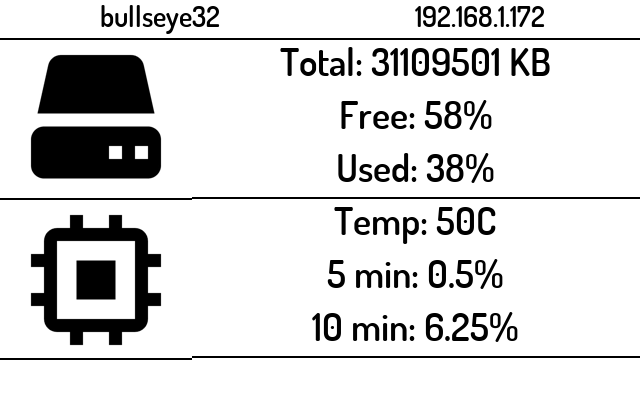

In [22]:
# # this code snip simulates running from within the display loop use this and the following
# # cell to test the output
# # fugly hack for making the library module available to the plugins
# import sys
# sys.path.append(layout.dir_path+'/../..')
# from library import PluginTools
# import logging
# logging.root.setLevel('WARNING')
# from library.CacheFiles import CacheFiles
# from library.Plugin import Plugin
# from IPython.display import display
# test_plugin = Plugin(resolution=(640, 400), screen_mode='RGB')
# test_plugin.layout = layout.layout
# test_plugin.config = {
#     'text_color': 'Black',
#     'bkground_color': 'white',
#     'storage_unit': 'KB',
# }
# test_plugin.refresh_rate = 5
# # l = layout.layout
# # test_plugin.cache = CacheFiles()
# test_plugin.update_function = update_function
# test_plugin.update()
# test_plugin.image

In [36]:
!jupyter-nbconvert --to python --template python_clean system_info.ipynb

[NbConvertApp] Converting notebook system_info.ipynb to python
[NbConvertApp] Writing 6528 bytes to system_info.py
